In [2]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn

# 小数第三位まで表示
%precision 3

'%.3f'

In [3]:
# インポート
import requests, zipfile
import io

# キノコデータを取得
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content

# 取得したデータをDataFrameオブジェクトとして読み込み
mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)


In [4]:
# データの列にラベルを設定
mushroom.columns = ['classes', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 
                    'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 
                    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
                    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
                    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'] 

In [5]:
print('データの形式:{}'.format(mushroom.shape))
print('欠損の数:{}'.format(mushroom.isnull().sum().sum()))

データの形式:(8124, 23)
欠損の数:0


In [6]:
mushroom_dummy = pd.get_dummies(mushroom[['gill-color', 'gill-attachment', 'odor', 'cap-color']])

,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,...,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
# 目的変数もフラグ化(0/1)する
mushroom_dummy['flg'] = mushroom['classes'].map(lambda x: 1 if x == 'p' else 0)

In [8]:
mushroom_dummy.head()

,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,...,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,flg
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [10]:
mushroom_dummy.groupby(['cap-color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap-color_c,,
0,4176,3904
1,32,12


In [14]:
mushroom_dummy.groupby(['gill-color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill-color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [37]:
def calc_entropy(p):
    if p < 0:
        return 0
    elif p == 0:
        return - ((1 - p) * np.log2(1 - p))
    elif 1 < p:
        return 0
    elif p == 1:        
        return - (p * np.log2(p))
    else:
        return - (p * np.log2(p) + (1 - p) * np.log2(1 - p))

In [16]:
print(calc_entropy(0.5))
print(calc_entropy(0.001))

1.0
0.011407757737461138


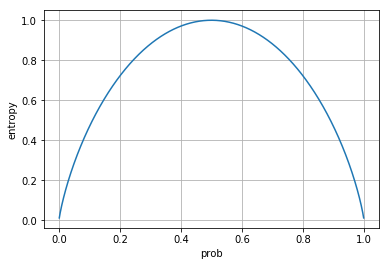

In [21]:
# pの値を0.001から0.999まで0.01刻みで動かす
p = np.arange(0.001, 1.000, 0.001)

# グラフ化
plt.plot(p, calc_entropy(p))
plt.xlabel('prob')
plt.ylabel('entropy')
plt.grid(True)

In [24]:
mushroom_dummy.groupby(['flg'])['flg'].count()

flg
0    4208
1    3916
Name: flg, dtype: int64

In [28]:
entropy_init = calc_entropy(4208/(4208+3916))
print('毒キノコデータのエントロピーの初期値:{:.3f}'.format(entropy_init))

毒キノコデータのエントロピーの初期値:0.999


In [30]:
mushroom_dummy.groupby(['cap-color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap-color_c,,
0,4176,3904
1,32,12


In [31]:
# cap-colorがcでない場合のエントロピー
calc_entropy(4176/(4176+3904))

0.9991823984904757

In [32]:
# cap-colorがcでない場合のエントロピー
calc_entropy(32/(32+12))

0.8453509366224364

In [33]:
entropy_after = ((4176+3904)/8124) * calc_entropy(4176/(4176+3904)) + ((32+12)/8124) * calc_entropy(32/(32+12))
print('データ分割後の平均エントロピー:{:.3f}'.format(entropy_after))

データ分割後の平均エントロピー:0.998


In [34]:
print('変数の分割によって得られる情報利得:{:.3f}'.format(entropy_init - entropy_after))

変数の分割によって得られる情報利得:0.001


In [40]:
mushroom_dummy.groupby(['gill-color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill-color_b,,
0,4208.0,2188.0
1,NaN,1728.0


In [41]:
entropy_after = ((4208+2188)/8124) * calc_entropy(4208/(4208+2188)) + ((0+1728)/8124) * calc_entropy(0/(0+1728))
print('データ分割後の平均エントロピー:{:.3f}'.format(entropy_after))

データ分割後の平均エントロピー:0.730


In [42]:
print('変数の分割によって得られる情報利得:{:.3f}'.format(entropy_init - entropy_after))

変数の分割によって得られる情報利得:0.269


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# データ分割
X = mushroom_dummy.drop('flg', axis=1)
y = mushroom_dummy['flg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
model.fit(X_train, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.991
正解率(test):0.992
